In [1]:
# Generic OpenAI-compatible endpoint using ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from IPython.display import Image, display

import os
default_model_name = os.environ["OPENAI_MODEL"]
pg_connection = os.environ["PGVECTOR_CONNECTION_STRING"]
llm = ChatOpenAI(model=default_model_name,temperature=0)

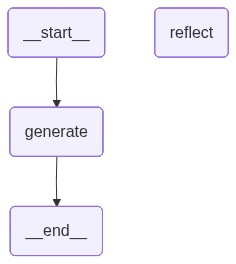

In [2]:
from typing import Annotated, TypedDict

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_openai import ChatOpenAI

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

model = llm

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

generate_prompt = SystemMessage(
    """Anda adalah asisten esai yang ditugaskan menulis esai 3-paragraf yang
        sangat baik."""
    "Hasilkan esai terbaik yang mungkin untuk permintaan pengguna."
    """Jika pengguna memberikan kritik, tanggapi dengan versi revisi dari
        upaya Anda sebelumnya."""
)

def generate(state: State) -> State:
    answer = model.invoke([generate_prompt] + state["messages"])
    return {"messages": [answer]}

reflection_prompt = SystemMessage(
    """Anda adalah guru yang menilai pengajuan esai. Hasilkan kritik dan
        rekomendasi untuk pengajuan pengguna."""
    """Berikan rekomendasi terperinci, termasuk permintaan untuk panjang, kedalaman,
        gaya, dll."""
)

def reflect(state: State) -> State:
    # Balikkan pesan untuk membuat LLM berefleksi pada keluaran sendiri
    cls_map = {AIMessage: HumanMessage, HumanMessage: AIMessage}
    # Pesan pertama adalah permintaan pengguna asli.
    # kita pertahankan sama untuk semua simpul
    translated = [reflection_prompt, state["messages"][0]] + [
        cls_map[msg.__class__](content=msg.content)
            for msg in state["messages"][1:]
    ]
    answer = model.invoke(translated)
    # kita perlakukan keluaran ini sebagai umpan balik manusia untuk generator
    return {"messages": [HumanMessage(content=answer.content)]}

def should_continue(state: State):
    if len(state["messages"]) > 6:
        # Berhenti setelah 3 iterasi, masing-masing dengan 2 pesan
        return END
    else:
        return "reflect"

builder = StateGraph(State)
builder.add_node("generate", generate)
builder.add_node("reflect", reflect)
builder.add_edge(START, "generate")
builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

graph = builder.compile()
png_bytes =graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))